# Create Spark Cluster

In [1]:
from pyspark.sql import SparkSession
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)

In [2]:
import socket
port = spark.sparkContext.uiWebUrl.split(":")[-1]
hostname = socket.gethostname()
print(f"https://{hostname}/jupyter/user/stevengs/proxy/{port}/jobs/")

https://epyc.astro.washington.edu/jupyter/user/stevengs/proxy/4043/jobs/


# Load current cut of lightcurves

In [3]:
import axs
catalog = axs.AxsCatalog(spark)
wtf = catalog.load("stevengs_cut_wtf")

Look at the light curve/dib schema

In [4]:
print(wtf.columns)

['ps1_objid', 'ra', 'dec', 'mean_mag_g', 'mean_mag_r', 'mean_mag_i', 'ra_stddev', 'dec_stddev', 'ps1_gMeanPSFMag', 'ps1_rMeanPSFMag', 'ps1_iMeanPSFMag', 'ra_detections', 'dec_detections', 'mjd_g', 'mag_g', 'magerr_g', 'psfflux_g', 'psffluxerr_g', 'catflags_g', 'expid_g', 'rcID_g', 'fieldID_g', 'xpos_g', 'ypos_g', 'nobs_g', 'mjd_r', 'mag_r', 'magerr_r', 'psfflux_r', 'psffluxerr_r', 'catflags_r', 'expid_r', 'rcID_r', 'fieldID_r', 'xpos_r', 'ypos_r', 'nobs_r', 'mjd_i', 'mag_i', 'magerr_i', 'psfflux_i', 'psffluxerr_i', 'catflags_i', 'expid_i', 'rcID_i', 'fieldID_i', 'xpos_i', 'ypos_i', 'nobs_i', 'dip', 'zone', 'dup']


In [5]:
# dip schema
wtf.select("dip").head(1)[0]

Row(dip=Row(center_mjd=58282.18359375, start_mjd=58271.09765625, end_mjd=58293.70703125, length=22.608280181884766, guess_start_mjd=58274.85546875, guess_end_mjd=58286.29296875, guess_significance=7.1239423751831055, window_start_mjd=58263.421875, window_end_mjd=58297.73046875, significant_observation_count=5, significant_length=9.91579818725586, integral=0.730926513671875, integral_uncertainty=0.13865260779857635, significance=5.271639347076416, max_gap=10.001840591430664, max_gap_fraction=0.44239720702171326, core_count=6, core_start_mjd=58276.35546875, core_end_mjd=58286.26953125, core_length=9.91579818725586, core_significant_count=5, core_not_significant_count=1, core_not_significant_fraction=0.1666666716337204, ref_observation_count_before=10, ref_observation_count_after=218, ref_observation_count=228, ref_pull_std=1.4057750701904297, ref_large_pull_fraction=0.048245612531900406, ref_length_after=573.8453369140625, ref_length_before=57.98050308227539, ref_length=631.8258056640625

In [6]:
from fit_utils import (
    fit_band_around_dip, plot_fit_result, make_udf_from_annotated_function,
    evaluate_in_dip, evaluate_around_dip, evaluate
)

# Test simple quadratic model

In [12]:
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# fit model to data in window around the dip
# fit r-band data
# fit in window that is expanded by 4.0x the dip width from dip.start_mjd and dip.end_mjd
quadratic_fit_df = fit_band_around_dip(wtf, quadratic, "r", 4.0)

# select a small subset of columns
quadratic_fit_df_slim = quadratic_fit_df.select(
    "ps1_objid",
    "ra",
    "dec",
    "zone",
    "mjd_r",
    "mag_r",
    "magerr_r",
    "dip",
    "window_r",
    "fit_r",
)

# only include fits that converged
quadratic_fit_df_slim_good = quadratic_fit_df_slim.where(
    quadratic_fit_df_slim['fit_r']['info']['good']
)
# evaluate sum square error inside the dip
fits_evaluated_df = evaluate_in_dip(quadratic_fit_df_slim_good, quadratic, "r")
# around the dip
fits_evaluated_df = evaluate_around_dip(fits_evaluated_df, quadratic, "r", 4.0)
# over all data
fits_evaluated_df = evaluate(fits_evaluated_df, quadratic, "r")

In [13]:
lc = fits_evaluated_df.head(1)[0]

## in-dip

Row(sum_square_error=246.16676330566406, reduced_sum_square_error=1.0565097332000732)


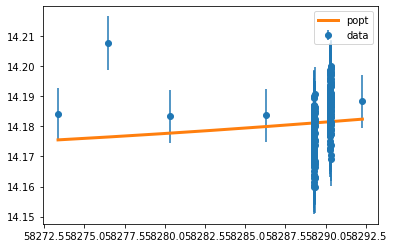

In [14]:
plot_fit_result(lc['dip_window_r']['x'], lc['dip_window_r']['y'], lc['dip_window_r']['yerr'], lc['fit_r'], quadratic)
print(lc['model_error_in_dip_r'])

## around-dip

Row(sum_square_error=369.5804443359375, reduced_sum_square_error=1.5271918773651123)


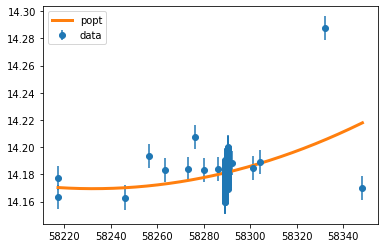

In [15]:
plot_fit_result(lc['window_r']['x'], lc['window_r']['y'], lc['window_r']['yerr'], lc['fit_r'], quadratic)
print(lc['model_error_around_dip_r'])

## all-data

Row(sum_square_error=1251659.25, reduced_sum_square_error=2800.132568359375)


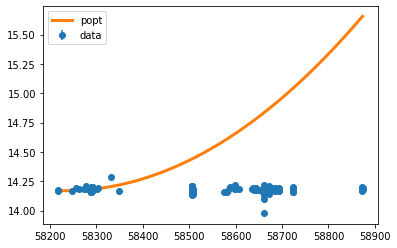

In [16]:
plot_fit_result(lc['mjd_r'], lc['mag_r'], lc['magerr_r'], lc['fit_r'], quadratic)
print(lc['model_error_r'])

# Skew Normal

Description: https://en.wikipedia.org/wiki/Skew_normal_distribution

A combination of the standard normal PDF $\phi(x)$ and the standard  normal CDF $\Phi(x)$:

$$
f(x) = \frac{2}{\omega} \phi\left(\frac{x - \xi}{\omega} \right) \Phi\left(\alpha \left(\frac{x - \xi}{\omega} \right) \right)
$$
$\xi$ is the location, $\omega$ is the scale, $\alpha$ is the skew.

\begin{align*}
\phi(x) &= \frac{1}{2\pi} \exp\left( -\frac{x^2}{2} \right) \\
\Phi(x) &= \int_{-\infty}^{x} \phi(t) dt = \frac{1}{2} \left[ 1 + \text{erf}\left( \frac{x}{\sqrt{2}} \right) \right]
\end{align*}

In [17]:
from models import skew_normal, skew_normal_p0, skew_normal_p0_udf

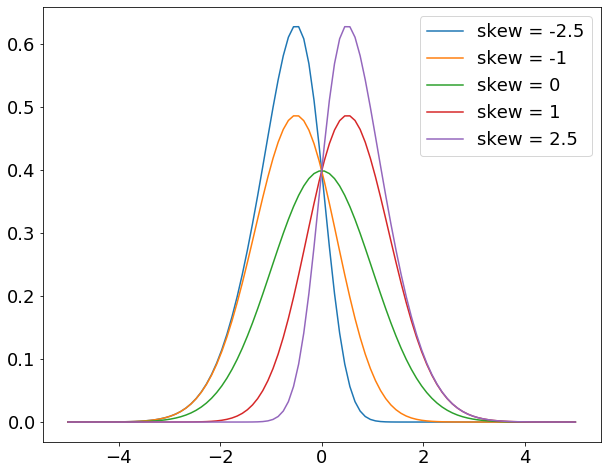

In [20]:
import matplotlib.pyplot as plt
import numpy as np

loc = 0
xscale = 1
yscale = 1
offset = 0
plt.rc("figure", figsize=[10, 8])
plt.rc("font", size=18)
for skew in [-2.5, -1,  0, 1, 2.5]:
    _x = np.linspace(-5, 5, 100)
    _y = skew_normal(_x, skew, loc, xscale, yscale, offset)
    plt.plot(_x, _y, label=f"skew = {skew}")
plt.legend()
plt.show()

Fit r-band data

In [21]:
band = "r"
wiggle = 4.0

skew_normal_p0_column = skew_normal_p0_udf(
    wtf['mjd_r'], wtf['mag_r'], wtf['magerr_r'], wtf['dip']['start_mjd'], 
    wtf['dip']['end_mjd'], wtf['dip']['integral']
)

skew_norm_fit_df = fit_band_around_dip(wtf, skew_normal, band, wiggle, p0=skew_normal_p0_column)

# select a small subset of columns
skew_norm_fit_df_slim = skew_norm_fit_df.select(
    "ps1_objid",
    "ra",
    "dec",
    "zone",
    "mjd_r",
    "mag_r",
    "magerr_r",
    "dip",
    "window_r",
    "fit_r",
)

# only include fits that converged
skew_norm_fit_df_slim_good = skew_norm_fit_df_slim.where(
    skew_norm_fit_df_slim['fit_r']['info']['good']
)
# evaluate sum square error inside the dip
skew_norm_fits_evaluated_df = evaluate_in_dip(skew_norm_fit_df_slim_good, skew_normal, band)
# around the dip
skew_norm_fits_evaluated_df = evaluate_around_dip(skew_norm_fits_evaluated_df, skew_normal, band, wiggle)
# over all data
skew_norm_fits_evaluated_df = evaluate(skew_norm_fits_evaluated_df, skew_normal, band)

In [22]:
_lc = skew_norm_fits_evaluated_df.head(1)[0]

Row(sum_square_error=247.902099609375, reduced_sum_square_error=1.073169231414795)
Row(sum_square_error=402.0196228027344, reduced_sum_square_error=1.675081729888916)
Row(sum_square_error=1538.3634033203125, reduced_sum_square_error=3.456996440887451)


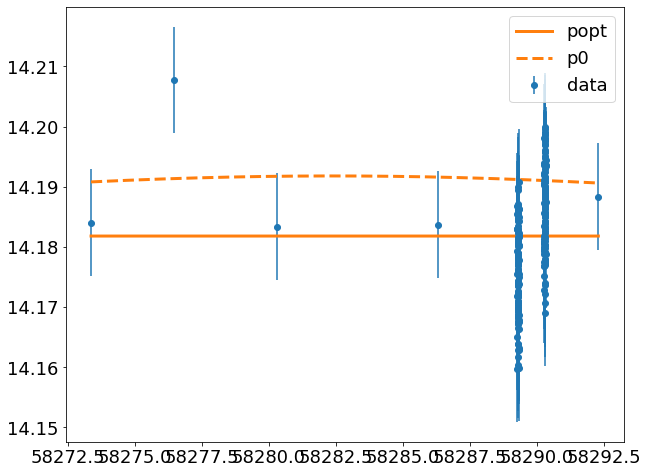

In [23]:
plot_fit_result(
    _lc['dip_window_r']['x'], _lc['dip_window_r']['y'], _lc['dip_window_r']['yerr'], 
    _lc['fit_r'], skew_normal, with_p0=True
)
print(_lc['model_error_in_dip_r'])
print(_lc['model_error_around_dip_r'])
print(_lc['model_error_r'])

In [38]:
catalog.save_axs_table(skew_norm_fits_evaluated_df, "6_4_20_stevengs_skew_normal_fits_r_band")

# Top hat

\begin{align}
f(x) = \begin{cases}
d + c&\text{for $x\in[l - w/2, l + w/2]$}\\
c&\text{otherwise}\\
\end{cases}
\end{align}
where $d$ is the depth, $c$ is the offset, $l$ is the location, and $w$ is the width

In [26]:
from models import top_hat, top_hat_p0, top_hat_p0_udf

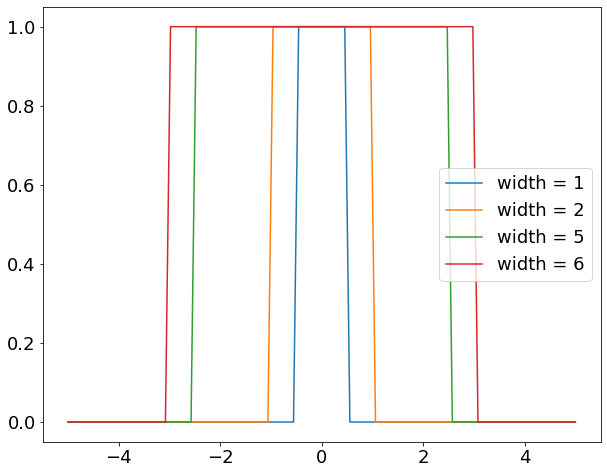

In [27]:
loc = 0
width = 1
depth = 1
offset = 0
plt.rc("figure", figsize=[10, 8])
plt.rc("font", size=18)
for width in [1, 2, 5, 6]:
    _x = np.linspace(-5, 5, 100)
    _y = top_hat(_x, loc, width, depth, offset)
    plt.plot(_x, _y, label=f"width = {width}")
plt.legend()
plt.show()

In [30]:
band = "r"
wiggle = 4.0

top_hat_p0_column = top_hat_p0_udf(
    wtf['mjd_r'], wtf['mag_r'], wtf['magerr_r'], 
    wtf['dip']['start_mjd'], wtf['dip']['end_mjd'], wtf['dip']['integral']
)

top_hat_fit_df = fit_band_around_dip(wtf, top_hat, band, wiggle, p0=top_hat_p0_column)

# select a small subset of columns
top_hat_fit_df_slim = top_hat_fit_df.select(
    "ps1_objid",
    "ra",
    "dec",
    "zone",
    "mjd_r",
    "mag_r",
    "magerr_r",
    "dip",
    "window_r",
    "fit_r",
)

# only include fits that converged
top_hat_fit_df_slim_good = top_hat_fit_df_slim.where(
    top_hat_fit_df_slim['fit_r']['info']['good']
)
# evaluate sum square error inside the dip
top_hat_fits_evaluated_df = evaluate_in_dip(top_hat_fit_df_slim_good, top_hat, band)
# around the dip
top_hat_fits_evaluated_df = evaluate_around_dip(top_hat_fits_evaluated_df, top_hat, band, wiggle)
# over all data
top_hat_fits_evaluated_df = evaluate(top_hat_fits_evaluated_df, top_hat, band)

In [31]:
catalog.save_axs_table(top_hat_fits_evaluated_df, "6_4_20_stevengs_top_hat_fits_r_band")

In [32]:
top_hat_lcs = catalog.load("6_4_20_stevengs_top_hat_fits_r_band")
top_hat_lc = top_hat_lcs.head(1)[0]

Row(sum_square_error=247.6127166748047, reduced_sum_square_error=1.0672962665557861)
Row(sum_square_error=394.15240478515625, reduced_sum_square_error=1.6354870796203613)
Row(sum_square_error=2046.572509765625, reduced_sum_square_error=4.5887274742126465)


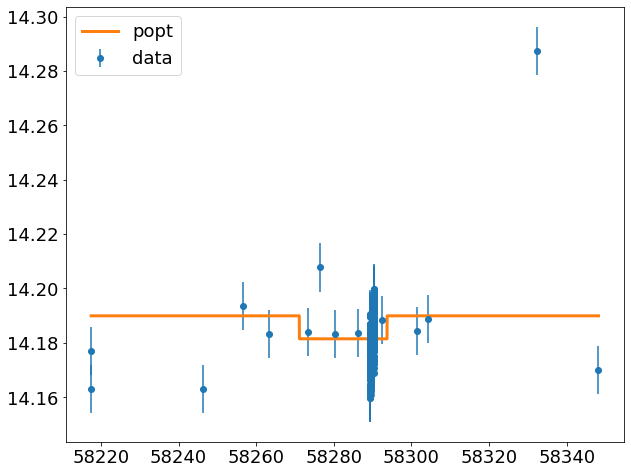

In [33]:
plot_fit_result(
    top_hat_lc['window_r']['x'], top_hat_lc['window_r']['y'], top_hat_lc['window_r']['yerr'], 
    top_hat_lc['fit_r'], top_hat
)
print(top_hat_lc['model_error_in_dip_r'])
print(top_hat_lc['model_error_around_dip_r'])
print(top_hat_lc['model_error_r'])

In [34]:
top_hat_lc_min_chi_square = top_hat_lcs.sort(
    top_hat_lcs['model_error_around_dip_r.reduced_sum_square_error'], ascending=True
).head(1)[0]

Row(sum_square_error=5.735997232747536e-10, reduced_sum_square_error=-1.9119991701010974e-10)
Row(sum_square_error=2.0852787494659424, reduced_sum_square_error=0.2606598436832428)
Row(sum_square_error=278.66546630859375, reduced_sum_square_error=2.3030202388763428)


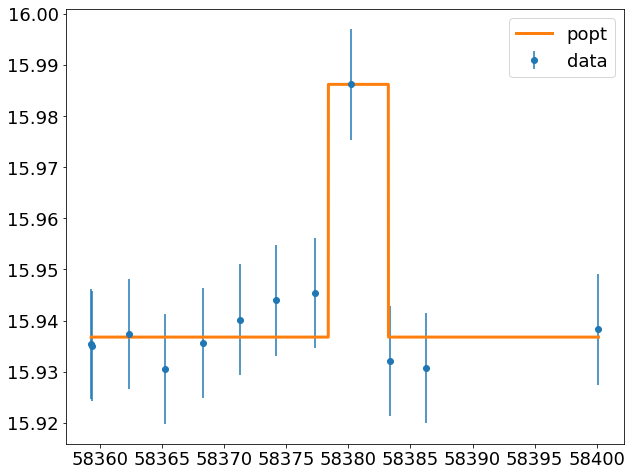

In [37]:
plot_fit_result(
    top_hat_lc_min_chi_square['around_dip_window_r']['x'], 
    top_hat_lc_min_chi_square['around_dip_window_r']['y'], 
    top_hat_lc_min_chi_square['around_dip_window_r']['yerr'], 
    top_hat_lc_min_chi_square['fit_r'], top_hat
)
print(top_hat_lc_min_chi_square['model_error_in_dip_r'])
print(top_hat_lc_min_chi_square['model_error_around_dip_r'])
print(top_hat_lc_min_chi_square['model_error_r'])